# VeronaCard Next‑POI Prediction – Metrics & Exploratory Analysis

*Generated automatically on 2025-06-25 13:01 UTC*

# 🎯 Obiettivi dell'Analisi

Questo notebook fornisce una **valutazione completa** delle performance del modello di predizione next-POI implementato in `veronacard_mob.py`, attraverso un framework di analisi strutturato e riproducibile.

## 📋 Pipeline di Analisi

### 🔄 **1. Data Loading & Preprocessing**
- **Caricamento automatico** di tutti i file CSV di predizione (`*_pred_*.csv`)
- **Parsing robusto** con gestione errori per file malformati
- **Estrazione automatica** dell'anno dai nomi file (es. `dati_2016_pred_model.csv` → 2016)
- **Validazione** delle predizioni (filtro per liste con esattamente 5 elementi)

### 📊 **2. Evaluation Metrics**
Calcolo di **quattro metriche standard** per sistemi di raccomandazione:
- **🎯 Top-1 Accuracy**: Precisione della predizione principale
- **📈 Top-5 Hit Rate**: Presenza del POI corretto nella top-5
- **⚡ Mean Reciprocal Rank (MRR)**: Qualità del ranking delle predizioni
- **🗂️ Catalogue Coverage**: Diversità delle raccomandazioni

### 📈 **3. Multi-level Visualization**
- **📊 Global metrics**: Performance aggregate su tutto il dataset
- **📅 Temporal analysis**: Trend evolutivo per anno (2016→2020)
- **🎨 Interactive charts**: Grafici comparativi e heat-maps

### 🔍 **4. Advanced Error Analysis Framework**
Sistema modulare ed estendibile per analisi approfondita:
- **🚨 Worst-case analysis**: Identificazione delle coppie POI più problematiche
- **🔥 Confusion matrices**: Visualizzazione degli errori sui POI più frequenti
- **🧠 Explainability**: Analisi dei pattern testuali che causano errori (LIME/SHAP-ready)
- **📊 Temporal patterns**: Analisi stagionale e trend temporali degli errori

## 🏗️ Caratteristiche Architetturali

### **✅ Robustezza**
- **Error handling** completo per file CSV corrotti
- **Graceful degradation** per dipendenze mancanti (LIME, etc.)
- **Validation** automatica dei dati di input

### **🔧 Flessibilità**
- **Path-agnostic**: Funziona con CSV nella cartella corrente o tramite `DATA_DIR`
- **Modular design**: Sezioni indipendenti eseguibili singolarmente
- **Extensible framework**: Facile aggiungere nuove metriche o analisi

### **📊 Riproducibilità**
- **Timestamp automatico** nel titolo
- **Seed fisso** per operazioni random
- **Versioning implicito** tramite nomi file con data

---

## 🚀 Quick Start

```python
# Esecuzione standard - CSV nella cartella 'results/'
# Nessuna configurazione richiesta

# Esecuzione personalizzata
DATA_DIR = "/path/to/your/csv/files"  # opzionale
```

## 📁 Struttura File Attesa

```
project_root/
├── notebook.ipynb           # questo notebook
├── results/                 # directory predefinita
│   ├── dati_2016_pred_model1.csv
│   ├── dati_2017_pred_model1.csv
│   └── ...
└── veronacard_mob.py       # script di generazione predizioni
```

---

> **💡 Pro Tip**: Il notebook è progettato per **fail-safe operation** — anche se alcuni file sono corrotti o alcune librerie mancano, l'analisi procede con le parti disponibili e fornisce sempre risultati utili.

In [ ]:

from pathlib import Path
import ast
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 120
plt.rcParams['axes.grid'] = True

DATA_DIR = "../results/qwen2.5_7b/base_version_second/" 
#DATA_DIR = "../results_parziali_sequenziali_ministral/" 
#DATA_DIR = "../result_run_completa_with_geom_srv_univr/" #llama 3.1:8b
#DATA_DIR = "../results"


## 1. Load data

In [2]:
from pathlib import Path
import glob, ast, os
import numpy as np
import pandas as pd

# Percorso ai file CSV
csv_files = [Path(p) for p in glob.glob(os.path.join(DATA_DIR, '*_pred_*.csv'))]
csv_files = sorted(csv_files)
assert csv_files, "No CSV files matching *_pred_*.csv found!"

dfs = []
for fp in csv_files:
    try:
        df = pd.read_csv(fp)
    except pd.errors.ParserError:
        print(f"Warning: Parser error in {fp}, trying with error handling...")
        df = pd.read_csv(fp, on_bad_lines='skip', engine='python')

    # Estrai l'anno dal nome file, es. dati_2016_pred_...
    year_token = next((part for part in fp.stem.split('_')
                       if part.isdigit() and len(part) == 4), None)
    df['year'] = int(year_token) if year_token else np.nan

    df['prediction_list'] = df['prediction'].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) else []
    )
    df = df[df['prediction_list'].apply(len) == 5]
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)
print(f"Loaded {len(df_all):,} rows from {len(csv_files)} files")
df_all.head()


Loaded 624,524 rows from 12 files


,card_id,cluster,history,current_poi,prediction,ground_truth,reason,hit,processing_time,status,year,prediction_list
0,040001523F3885,3,"['San Fermo', 'Santa Anastasia', 'Teatro Roman...",Arena,"['Castelvecchio', 'Sighseeing', 'Museo Lapidar...",Castelvecchio,These POIs are the nearest to the current loca...,True,91.464909,success,2014,"[Castelvecchio, Sighseeing, Museo Lapidario, C..."
1,040005523F3885,3,"['Casa Giulietta', 'Arena', 'Castelvecchio', '...",Duomo,"['AMO', 'Teatro Romano', 'Palazzo della Ragion...",Santa Anastasia,These suggestions are based on proximity to th...,False,91.694644,success,2014,"[AMO, Teatro Romano, Palazzo della Ragione, To..."
2,040002523F3885,3,"['San Fermo', 'Santa Anastasia', 'Teatro Roman...",Arena,"['Verona Tour', 'Museo Lapidario', 'Sighseeing...",Castelvecchio,These suggestions are based on the proximity o...,True,92.309289,success,2014,"[Verona Tour, Museo Lapidario, Sighseeing, Cas..."
3,04000E523F3885,3,"['San Fermo', 'Casa Giulietta', 'Santa Anastas...",Palazzo della Ragione,"['Duomo', 'Teatro Romano', 'Arena', 'AMO', 'Mu...",Castelvecchio,These suggestions are based on distance and to...,False,92.473927,success,2014,"[Duomo, Teatro Romano, Arena, AMO, Museo Conte]"
4,04000D523F3885,3,"['San Fermo', 'Casa Giulietta', 'Santa Anastas...",Palazzo della Ragione,"['Duomo', 'Teatro Romano', 'Arena', 'AMO', 'Mu...",Castelvecchio,These suggestions are based on distance and to...,False,92.783648,success,2014,"[Duomo, Teatro Romano, Arena, AMO, Museo Conte]"


# 2. Definizione delle Metriche di Valutazione

Per valutare le performance del modello di predizione next-POI, utilizziamo quattro metriche standard nel campo dei sistemi di raccomandazione e della predizione sequenziale.

## Notazione

Sia $y_i$ il vero next-POI (ground truth) per la sequenza $i$-esima, e sia $\hat{y}_i^{(1)}, \hat{y}_i^{(2)}, \ldots, \hat{y}_i^{(k)}$ la lista **ordinata** delle $k$ raccomandazioni prodotte dal modello per quella sequenza, dove $\hat{y}_i^{(1)}$ è la predizione con confidence più alta.

---

## 📊 Top-1 Accuracy

Misura la **precisione della predizione principale** del modello.

$$\text{Acc}_{@1} = \frac{1}{N}\sum_{i=1}^{N}\mathbf{1}\!\left\{y_i = \hat{y}_i^{(1)}\right\}$$

**Interpretazione**: Percentuale di casi in cui la prima predizione del modello coincide esattamente con il POI realmente visitato.

**Range**: [0, 1], dove 1 = predizione perfetta

---

## 🎯 Top-k Hit Rate

Misura se il POI corretto è presente **tra le prime $k$ predizioni**.

$$\text{HR}_{@k} = \frac{1}{N}\sum_{i=1}^{N}\mathbf{1}\!\left\{y_i \in \{\hat{y}_i^{(1)}, \hat{y}_i^{(2)}, \ldots, \hat{y}_i^{(k)}\}\right\}$$

**Interpretazione**: Percentuale di casi in cui il POI corretto è presente nella lista delle prime $k$ raccomandazioni. Per $k=5$: "Il modello include il POI corretto nella sua top-5?"

**Range**: [0, 1], sempre $\text{HR}_{@k} \geq \text{Acc}_{@1}$

---

## ⚡ Mean Reciprocal Rank (MRR)

Considera sia la **presenza** del POI corretto nella lista che la sua **posizione**.

$$\text{MRR} = \frac{1}{N}\sum_{i=1}^{N}\frac{1}{\text{rank}_i}$$

dove $\text{rank}_i = \min\{r \mid y_i = \hat{y}_i^{(r)}\}$ è la posizione del POI corretto nella lista ordinata.

**Interpretazione**: 
- Se il POI corretto è al 1° posto → contributo = 1.0
- Se il POI corretto è al 2° posto → contributo = 0.5  
- Se il POI corretto è al 5° posto → contributo = 0.2
- Se il POI corretto non è nella top-k → contributo = 0.0

**Range**: [0, 1], dove valori più alti indicano che i POI corretti appaiono nelle prime posizioni

---

## 🗂️ Catalogue Coverage  

Misura la **diversità** delle raccomandazioni prodotte dal modello.

$$\text{Coverage} = \frac{\left|\bigcup_{i=1}^{N}\{\hat{y}_i^{(1)}, \hat{y}_i^{(2)}, \ldots, \hat{y}_i^{(k)}\}\right|}{|\mathcal{P}|}$$

dove $\mathcal{P}$ è l'insieme completo dei POI presenti nel dataset (ground truth).

**Interpretazione**: Frazione dei POI disponibili che il modello è in grado di raccomandare. 
- Coverage = 1.0: il modello raccomanda tutti i POI del catalogo
- Coverage = 0.1: il modello raccomanda solo il 10% dei POI disponibili

**Importanza**: Previene il bias verso POI molto popolari e garantisce diversità nelle raccomandazioni.

---

## 💡 Note Metodologiche

- **$N$**: Numero totale di predizioni nel dataset di test
- **$k = 5$**: Utilizziamo consistently una finestra di 5 raccomandazioni
- **Ordinamento**: Le predizioni sono ordinate per confidence/probabilità decrescente
- **Handling missing**: Se $y_i \notin \{\hat{y}_i^{(1)}, \ldots, \hat{y}_i^{(k)}\}$, contributo = 0 per tutte le metriche

Queste metriche forniscono una **valutazione completa** del modello: precision (Acc@1), recall (HR@k), ranking quality (MRR), e diversity (Coverage).

### 2.1 Helper functions & per‑row computations

In [3]:
import json

def poi_id(x):
    """
    Converte 'x' in un identificatore hashable comparabile con ground-truth.
    • Se x è un dict          → prova a usare 'poi', 'poi_id', 'name', 'id'
    • Se x è list/tuple       → ritorna tupla ricorsiva
    • Altrimenti (str/int)    → cast a str
    """
    if isinstance(x, dict):
        for key in ('poi', 'poi_id', 'name', 'id'):
            if key in x:
                return str(x[key])
        # fallback: serializza in JSON ordinato
        return json.dumps(x, sort_keys=True)
    elif isinstance(x, (list, tuple)):
        return tuple(map(poi_id, x))
    else:
        return str(x)

# Normalizza prediction_list e ground_truth
df_all['prediction_norm']    = df_all['prediction_list'].apply(lambda lst: [poi_id(e) for e in lst])
df_all['ground_truth_norm']  = df_all['ground_truth'].apply(poi_id)

# -- metriche element-wise --------------------------------------------
df_all['hit@1'] = df_all['prediction_norm'].str[0] == df_all['ground_truth_norm']

def top_k_hit(row, k=5):
    return row['ground_truth_norm'] in row['prediction_norm'][:k]

def reciprocal_rank(row, k=5):
    try:
        rank = row['prediction_norm'][:k].index(row['ground_truth_norm']) + 1
        return 1.0 / rank
    except ValueError:
        return 0.0

df_all['hit@5'] = df_all.apply(top_k_hit, axis=1)
df_all['rr']    = df_all.apply(reciprocal_rank, axis=1)

### 2.2 Global metrics

In [4]:
metrics_global = {
    "Top-1 Accuracy": df_all["hit@1"].mean(),
    "Top-5 Hit Rate": df_all["hit@5"].mean(),
    "MRR": df_all["rr"].mean(),
}

# Catalogue Coverage
coverage_set = {poi for preds in df_all["prediction_norm"] for poi in preds}
metrics_global["Catalogue Coverage"] = (
    len(coverage_set) / df_all["ground_truth_norm"].nunique()
)

# Visualizza in percentuale
metrics_df = (
    pd.DataFrame(metrics_global, index=["Value"])
      .T
      .style.format("{:.2%}")
)
display(metrics_df)

,Value
Top-1 Accuracy,10.16%
Top-5 Hit Rate,48.29%
MRR,23.31%
Catalogue Coverage,313.64%


### 2.3 Metrics by year

In [5]:

by_year = (
    df_all
    .groupby('year')
    .agg(
        top1=('hit@1', 'mean'),
        hit5=('hit@5', 'mean'),
        mrr=('rr', 'mean'),
        n=('card_id', 'size')
    )
    .reset_index()
    .sort_values('year')
)
display(by_year)


,year,top1,hit5,mrr,n
0,2014,0.097631,0.469745,0.224268,65891
1,2015,0.100724,0.474496,0.229513,66677
2,2016,0.097691,0.471834,0.227964,70262
3,2017,0.095430,0.476573,0.225388,81337
4,2018,0.100316,0.487459,0.232801,78382
5,2019,0.104462,0.492909,0.238503,142444
6,2020,0.095409,0.463415,0.223248,13940
7,2021,0.115726,0.503662,0.251415,21983
8,2022,0.110421,0.494644,0.245379,72903
9,2023,0.094162,0.471555,0.226500,10705


## 3. Enhanced Visualizations

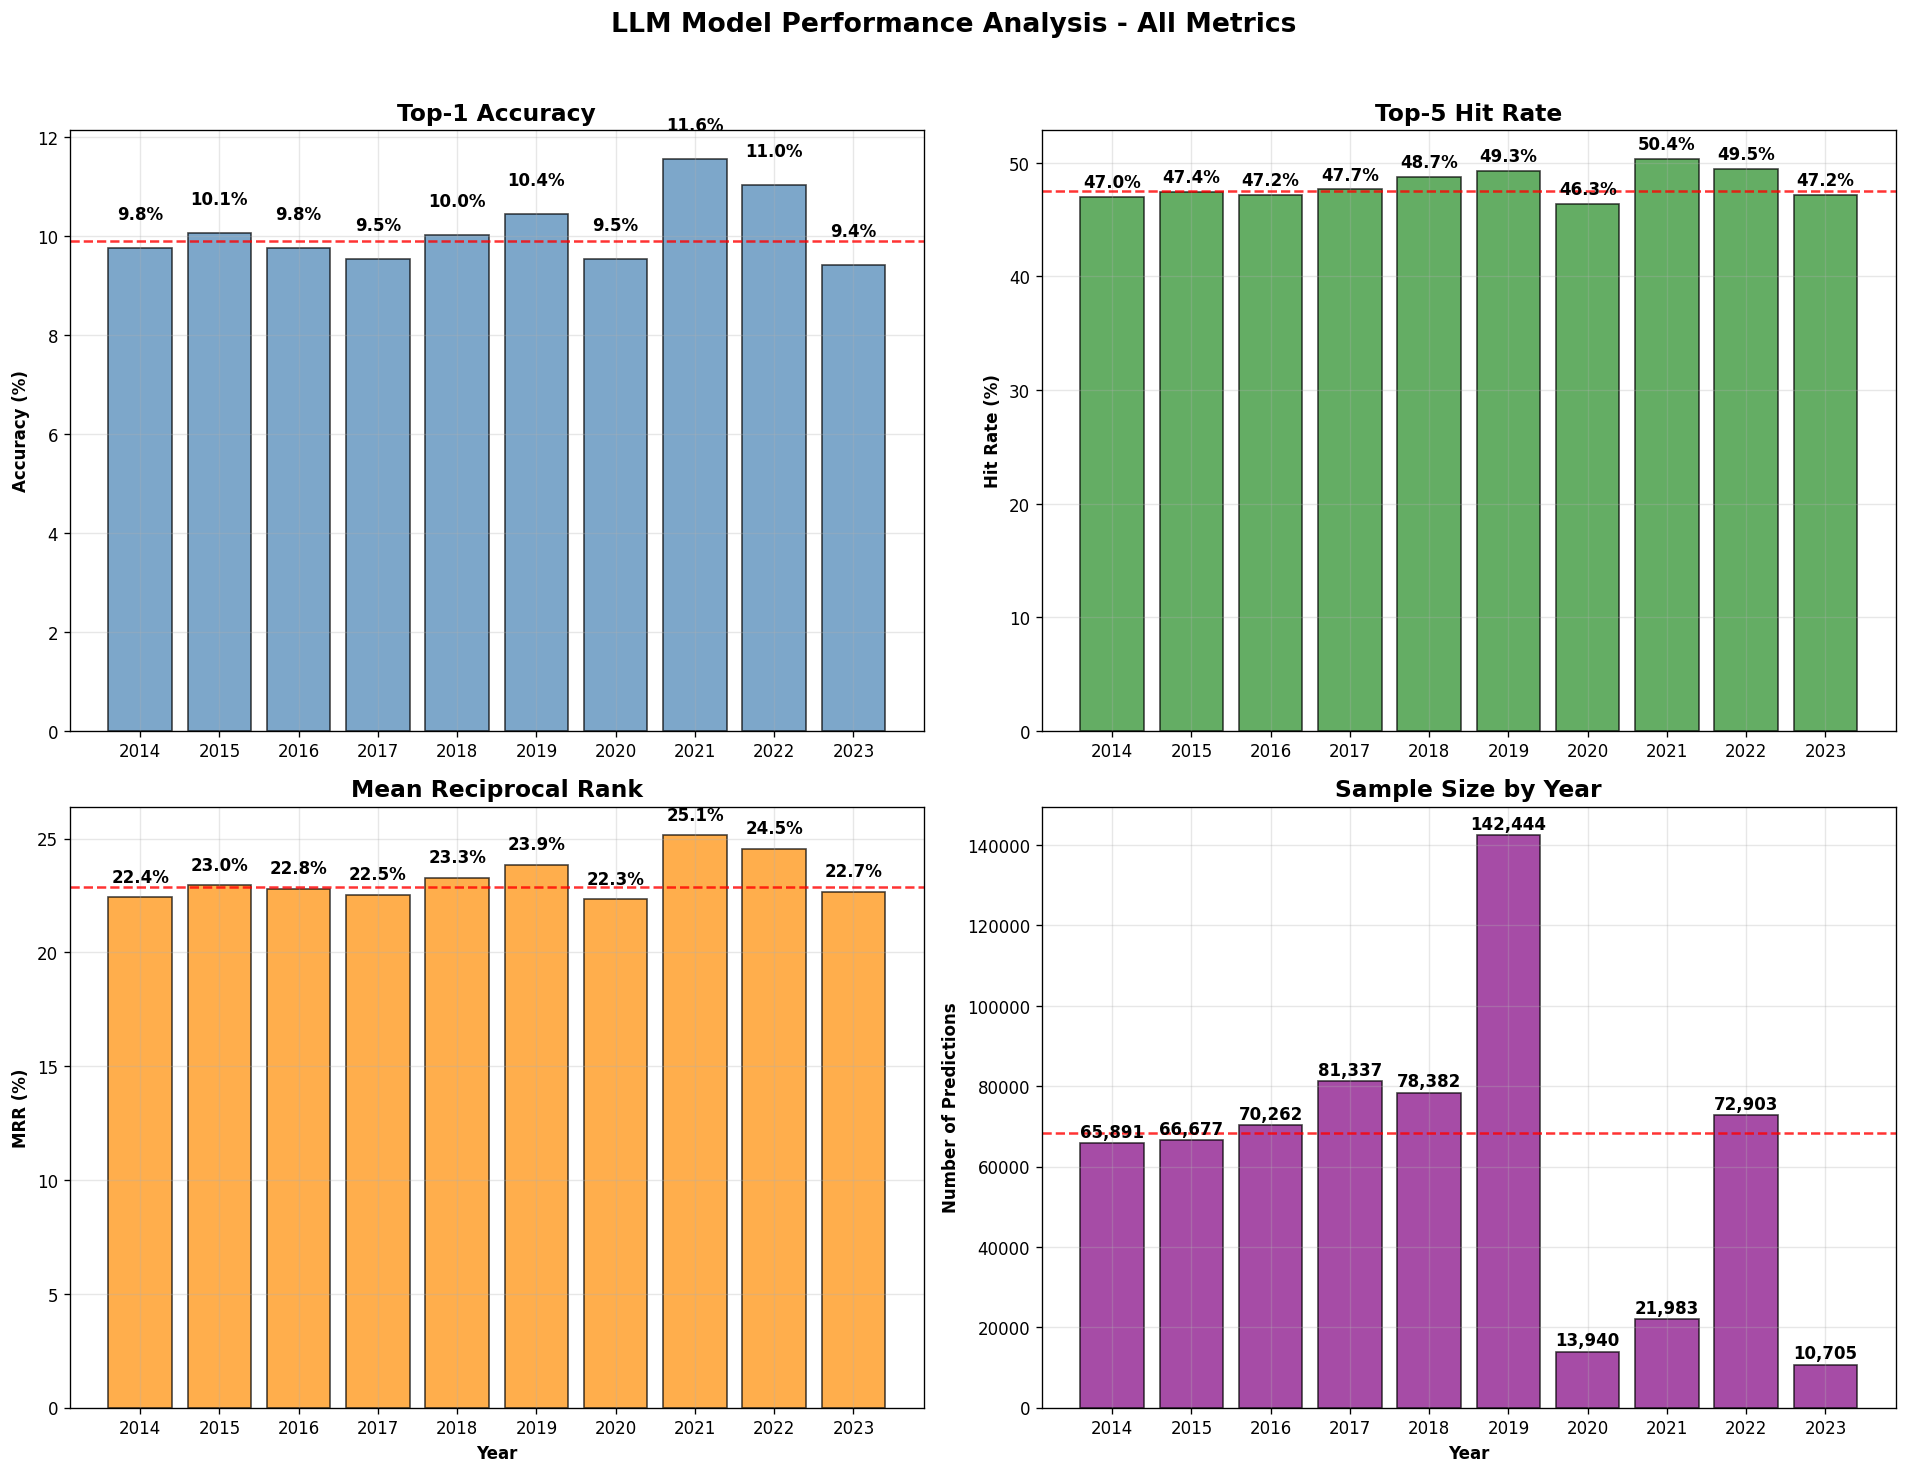

In [6]:
# Multi-metric comparison chart
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Top-1 Accuracy
bars1 = ax1.bar(by_year['year'].astype(str), by_year['top1']*100, 
                color='steelblue', alpha=0.7, edgecolor='black')
median1 = by_year['top1'].median() * 100
ax1.axhline(y=median1, color='red', linestyle='--', alpha=0.8)
for bar, value in zip(bars1, by_year['top1']*100):
    ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
             f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')
ax1.set_title('Top-1 Accuracy', fontweight='bold', fontsize=14)
ax1.set_ylabel('Accuracy (%)', fontweight='bold')
ax1.grid(True, alpha=0.3)

# Top-5 Hit Rate  
bars2 = ax2.bar(by_year['year'].astype(str), by_year['hit5']*100,
                color='forestgreen', alpha=0.7, edgecolor='black')
median2 = by_year['hit5'].median() * 100
ax2.axhline(y=median2, color='red', linestyle='--', alpha=0.8)
for bar, value in zip(bars2, by_year['hit5']*100):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
             f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')
ax2.set_title('Top-5 Hit Rate', fontweight='bold', fontsize=14)
ax2.set_ylabel('Hit Rate (%)', fontweight='bold')
ax2.grid(True, alpha=0.3)

# MRR
bars3 = ax3.bar(by_year['year'].astype(str), by_year['mrr']*100,
                color='darkorange', alpha=0.7, edgecolor='black')
median3 = by_year['mrr'].median() * 100
ax3.axhline(y=median3, color='red', linestyle='--', alpha=0.8)
for bar, value in zip(bars3, by_year['mrr']*100):
    ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
             f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')
ax3.set_title('Mean Reciprocal Rank', fontweight='bold', fontsize=14)
ax3.set_ylabel('MRR (%)', fontweight='bold')
ax3.set_xlabel('Year', fontweight='bold')
ax3.grid(True, alpha=0.3)

# Sample sizes
bars4 = ax4.bar(by_year['year'].astype(str), by_year['n'],
                color='purple', alpha=0.7, edgecolor='black')
median4 = by_year['n'].median()
ax4.axhline(y=median4, color='red', linestyle='--', alpha=0.8)
for bar, value in zip(bars4, by_year['n']):
    ax4.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 500,
             f'{value:,}', ha='center', va='bottom', fontweight='bold')
ax4.set_title('Sample Size by Year', fontweight='bold', fontsize=14)
ax4.set_ylabel('Number of Predictions', fontweight='bold')
ax4.set_xlabel('Year', fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.suptitle('LLM Model Performance Analysis - All Metrics', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

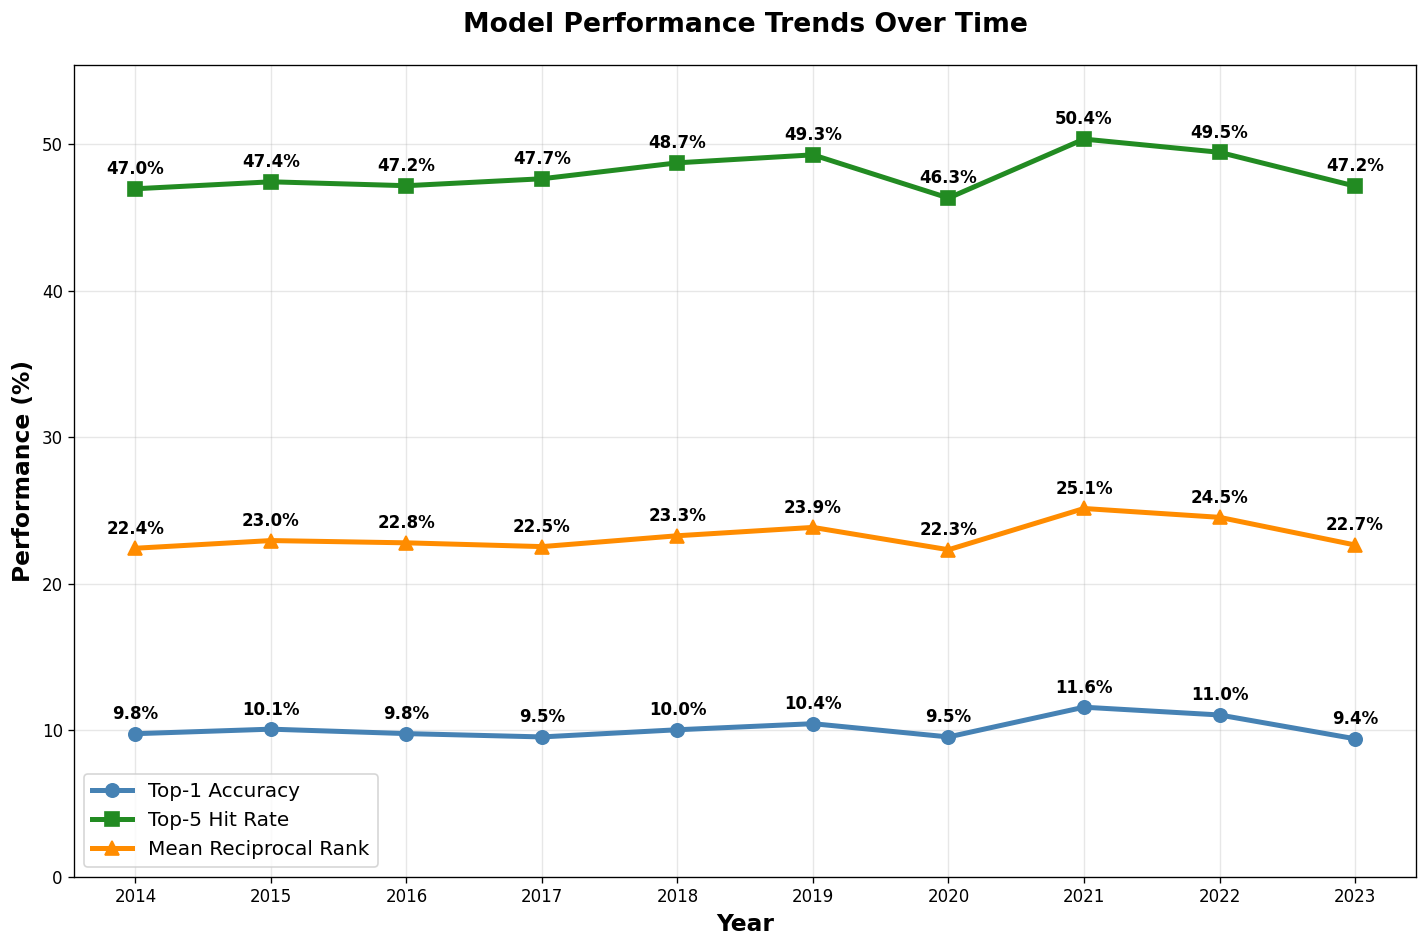

In [7]:
### 3.1 Performance Trends Analysis

# Line plot showing performance trends over years
fig, ax = plt.subplots(figsize=(12, 8))

# Plot all metrics as lines
x_years = by_year['year'].astype(int)
ax.plot(x_years, by_year['top1']*100, marker='o', linewidth=3, markersize=8, 
        label='Top-1 Accuracy', color='steelblue')
ax.plot(x_years, by_year['hit5']*100, marker='s', linewidth=3, markersize=8,
        label='Top-5 Hit Rate', color='forestgreen') 
ax.plot(x_years, by_year['mrr']*100, marker='^', linewidth=3, markersize=8,
        label='Mean Reciprocal Rank', color='darkorange')

# Add value annotations
for i, year in enumerate(x_years):
    ax.annotate(f"{by_year.iloc[i]['top1']*100:.1f}%", 
                (year, by_year.iloc[i]['top1']*100 + 1), 
                ha='center', fontsize=10, fontweight='bold')
    ax.annotate(f"{by_year.iloc[i]['hit5']*100:.1f}%", 
                (year, by_year.iloc[i]['hit5']*100 + 1), 
                ha='center', fontsize=10, fontweight='bold')
    ax.annotate(f"{by_year.iloc[i]['mrr']*100:.1f}%", 
                (year, by_year.iloc[i]['mrr']*100 + 1), 
                ha='center', fontsize=10, fontweight='bold')

# Styling
ax.set_xlabel('Year', fontsize=14, fontweight='bold')
ax.set_ylabel('Performance (%)', fontsize=14, fontweight='bold')
ax.set_title('Model Performance Trends Over Time', fontsize=16, fontweight='bold', pad=20)
ax.legend(fontsize=12, loc='best')
ax.grid(True, alpha=0.3)
ax.set_xticks(x_years)
ax.set_ylim(0, max(by_year['hit5']*100) * 1.1)

plt.tight_layout()
plt.show()

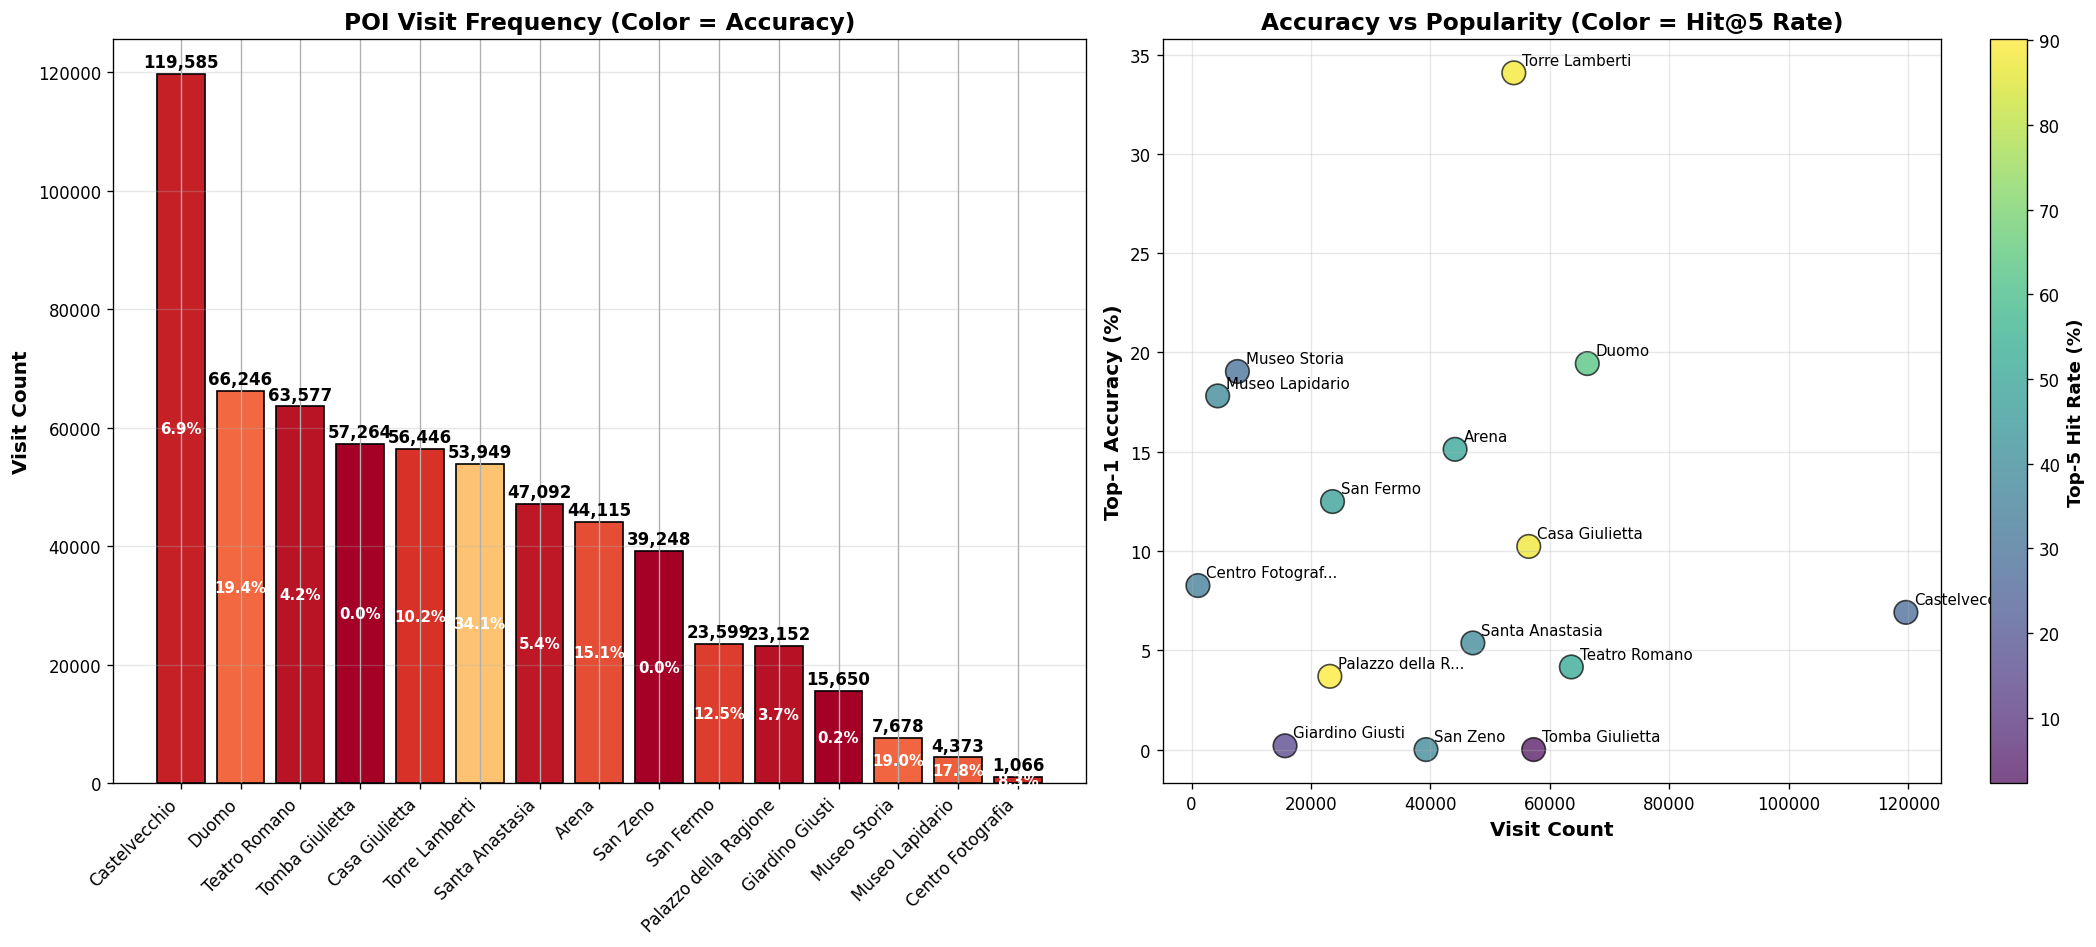


📊 POI Analysis Summary:
   • Most popular POI: Castelvecchio (119,585.0 visits)
   • Highest accuracy POI: Torre Lamberti (34.1%)
   • Correlation visit_count vs accuracy: -0.045


In [8]:
### 3.2 POI Popularity Distribution Analysis

# Analyze POI visit frequency and prediction accuracy
poi_stats = df_all.groupby('ground_truth_norm').agg({
    'hit@1': ['count', 'mean'],
    'hit@5': 'mean',
    'rr': 'mean'
}).round(4)

# Flatten column names
poi_stats.columns = ['visit_count', 'accuracy', 'hit5_rate', 'mrr']
poi_stats = poi_stats.sort_values('visit_count', ascending=False).head(15)

# Enhanced POI analysis visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Left plot: Visit counts with accuracy color coding
colors = plt.cm.RdYlGn(poi_stats['accuracy'])
bars1 = ax1.bar(range(len(poi_stats)), poi_stats['visit_count'], 
                color=colors, edgecolor='black', linewidth=1)

# Add value labels
for i, (bar, count, acc) in enumerate(zip(bars1, poi_stats['visit_count'], poi_stats['accuracy'])):
    ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 500,
             f'{count:,}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height()/2,
             f'{acc:.1%}', ha='center', va='center', fontweight='bold', 
             fontsize=9, color='white' if acc < 0.5 else 'black')

ax1.set_xticks(range(len(poi_stats)))
ax1.set_xticklabels(poi_stats.index, rotation=45, ha='right')
ax1.set_ylabel('Visit Count', fontsize=12, fontweight='bold')
ax1.set_title('POI Visit Frequency (Color = Accuracy)', fontsize=14, fontweight='bold')
ax1.grid(True, axis='y', alpha=0.3)

# Right plot: Accuracy vs Visit Count scatter
scatter = ax2.scatter(poi_stats['visit_count'], poi_stats['accuracy']*100, 
                     s=200, c=poi_stats['hit5_rate']*100, cmap='viridis', 
                     alpha=0.7, edgecolor='black')

# Add POI labels
for poi, row in poi_stats.iterrows():
    ax2.annotate(poi[:15] + ('...' if len(poi) > 15 else ''), 
                (row['visit_count'], row['accuracy']*100),
                xytext=(5, 5), textcoords='offset points', fontsize=9)

ax2.set_xlabel('Visit Count', fontsize=12, fontweight='bold')
ax2.set_ylabel('Top-1 Accuracy (%)', fontsize=12, fontweight='bold')
ax2.set_title('Accuracy vs Popularity (Color = Hit@5 Rate)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('Top-5 Hit Rate (%)', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\n📊 POI Analysis Summary:")
print(f"   • Most popular POI: {poi_stats.index[0]} ({poi_stats.iloc[0]['visit_count']:,} visits)")
print(f"   • Highest accuracy POI: {poi_stats.loc[poi_stats['accuracy'].idxmax()].name} ({poi_stats['accuracy'].max():.1%})")
print(f"   • Correlation visit_count vs accuracy: {poi_stats['visit_count'].corr(poi_stats['accuracy']):.3f}")

NameError: name 'pairs' is not defined

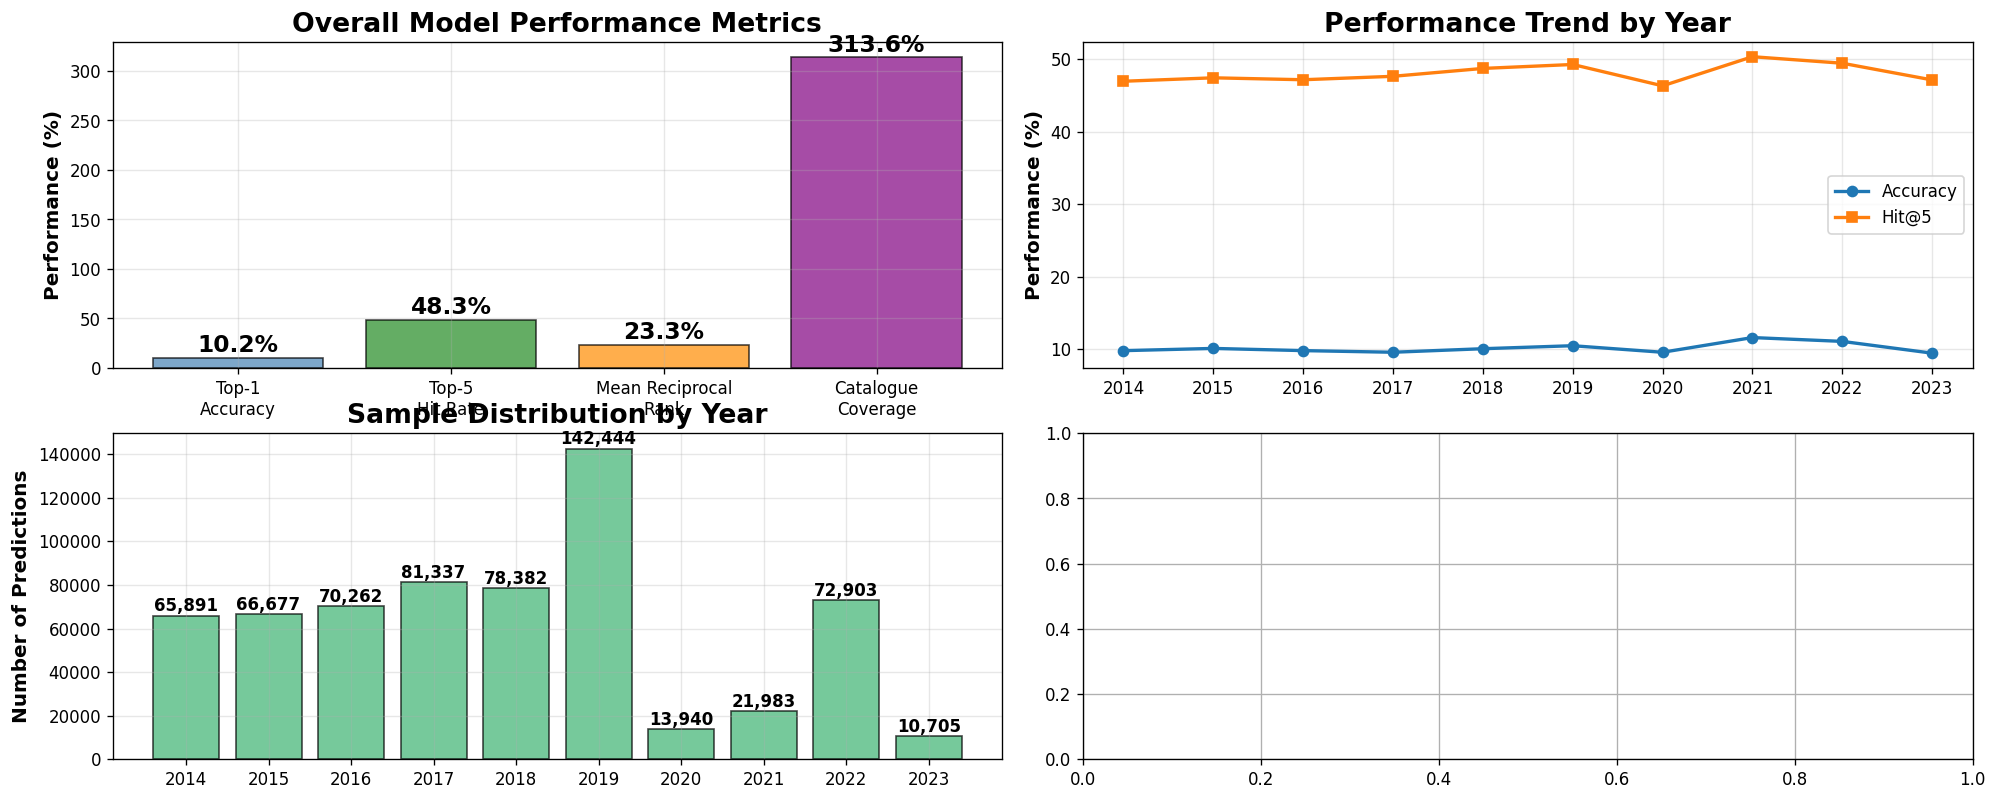

In [9]:
### 3.3 Model Performance Summary Dashboard

# Create comprehensive performance summary
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 4, height_ratios=[1, 1, 1], width_ratios=[1, 1, 1, 1])

# Overall metrics (top row)
ax_overall = fig.add_subplot(gs[0, :2])
metrics_values = [metrics_global["Top-1 Accuracy"]*100, 
                 metrics_global["Top-5 Hit Rate"]*100,
                 metrics_global["MRR"]*100,
                 metrics_global["Catalogue Coverage"]*100]
metrics_names = ["Top-1\nAccuracy", "Top-5\nHit Rate", "Mean Reciprocal\nRank", "Catalogue\nCoverage"]
colors = ['steelblue', 'forestgreen', 'darkorange', 'purple']

bars = ax_overall.bar(metrics_names, metrics_values, color=colors, alpha=0.7, edgecolor='black')
for bar, value in zip(bars, metrics_values):
    ax_overall.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1,
                   f'{value:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=14)
ax_overall.set_title('Overall Model Performance Metrics', fontsize=16, fontweight='bold')
ax_overall.set_ylabel('Performance (%)', fontsize=12, fontweight='bold')
ax_overall.grid(True, alpha=0.3)

# Year trend (top right)
ax_trend = fig.add_subplot(gs[0, 2:])
x_pos = range(len(by_year))
ax_trend.plot(x_pos, by_year['top1']*100, 'o-', linewidth=2, markersize=6, label='Accuracy')
ax_trend.plot(x_pos, by_year['hit5']*100, 's-', linewidth=2, markersize=6, label='Hit@5')
ax_trend.set_xticks(x_pos)
ax_trend.set_xticklabels(by_year['year'].astype(int))
ax_trend.set_title('Performance Trend by Year', fontsize=16, fontweight='bold')
ax_trend.set_ylabel('Performance (%)', fontsize=12, fontweight='bold')
ax_trend.legend()
ax_trend.grid(True, alpha=0.3)

# Sample distribution (middle left)
ax_samples = fig.add_subplot(gs[1, :2])
bars_samples = ax_samples.bar(by_year['year'].astype(str), by_year['n'], 
                             color='mediumseagreen', alpha=0.7, edgecolor='black')
for bar, value in zip(bars_samples, by_year['n']):
    ax_samples.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 200,
                   f'{value:,}', ha='center', va='bottom', fontweight='bold', fontsize=10)
ax_samples.set_title('Sample Distribution by Year', fontsize=16, fontweight='bold')
ax_samples.set_ylabel('Number of Predictions', fontsize=12, fontweight='bold')
ax_samples.grid(True, alpha=0.3)

# Top errors (middle right)
ax_errors = fig.add_subplot(gs[1, 2:])
top_errors = pairs.head(8)
bars_err = ax_errors.barh(range(len(top_errors)), top_errors['errors'],
                         color='lightcoral', alpha=0.7, edgecolor='black')
ax_errors.set_yticks(range(len(top_errors)))
ax_errors.set_yticklabels([f"{row['ground_truth_norm'][:8]}→{row['first_pred'][:8]}" 
                          for _, row in top_errors.iterrows()], fontsize=9)
ax_errors.set_title('Top Error Patterns', fontsize=16, fontweight='bold')
ax_errors.set_xlabel('Error Count', fontsize=12, fontweight='bold')
ax_errors.grid(True, alpha=0.3)

# Performance by POI popularity (bottom)
ax_poi_perf = fig.add_subplot(gs[2, :])
top_poi_for_viz = poi_stats.head(10)
x_poi = range(len(top_poi_for_viz))

# Dual y-axis plot
ax_poi_perf2 = ax_poi_perf.twinx()

bars_visits = ax_poi_perf.bar([x - 0.2 for x in x_poi], top_poi_for_viz['visit_count'], 
                             width=0.4, color='lightblue', alpha=0.7, label='Visit Count')
bars_acc = ax_poi_perf2.bar([x + 0.2 for x in x_poi], top_poi_for_viz['accuracy']*100,
                           width=0.4, color='orange', alpha=0.7, label='Accuracy (%)')

ax_poi_perf.set_xticks(x_poi)
ax_poi_perf.set_xticklabels([poi[:10] + ('...' if len(poi) > 10 else '') 
                           for poi in top_poi_for_viz.index], rotation=45, ha='right')
ax_poi_perf.set_title('Performance vs Popularity - Top 10 POI', fontsize=16, fontweight='bold')
ax_poi_perf.set_ylabel('Visit Count', fontsize=12, fontweight='bold', color='blue')
ax_poi_perf2.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold', color='orange')
ax_poi_perf.grid(True, alpha=0.3)

# Add legends
ax_poi_perf.legend(loc='upper left')
ax_poi_perf2.legend(loc='upper right')

plt.suptitle('🎯 LLM-Mob Model Performance Dashboard', fontsize=20, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Enhanced bar chart for Top-1 Accuracy
fig, ax = plt.subplots(figsize=(12, 8))

# Create bars
bars = ax.bar(by_year['year'].astype(str), by_year['top1']*100, 
              color='steelblue', alpha=0.7, edgecolor='black', linewidth=1.2)

# Add median line
median_value = by_year['top1'].median() * 100
ax.axhline(y=median_value, color='red', linestyle='--', linewidth=2, 
           label=f'Median: {median_value:.1f}%', alpha=0.8)

# Add value labels on each bar
for bar, value in zip(bars, by_year['top1']*100):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{value:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)

# Styling improvements
ax.set_ylabel('Top-1 Accuracy (%)', fontsize=14, fontweight='bold')
ax.set_xlabel('Year', fontsize=14, fontweight='bold')
ax.set_title('Top-1 Accuracy (%) by Year', fontsize=16, fontweight='bold', pad=20)
ax.grid(True, axis='y', alpha=0.3, linestyle='-')
ax.set_ylim(0, max(by_year['top1']*100) * 1.15)
ax.legend(fontsize=12)

# Add sample size annotations
for i, (bar, n) in enumerate(zip(bars, by_year['n'])):
    ax.text(bar.get_x() + bar.get_width()/2., -max(by_year['top1']*100) * 0.05,
            f'n={n:,}', ha='center', va='top', fontsize=10, alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Enhanced bar chart for Top-5 Hit Rate
fig, ax = plt.subplots(figsize=(12, 8))

# Create bars
bars = ax.bar(by_year['year'].astype(str), by_year['hit5']*100, 
              color='forestgreen', alpha=0.7, edgecolor='black', linewidth=1.2)

# Add median line
median_value = by_year['hit5'].median() * 100
ax.axhline(y=median_value, color='red', linestyle='--', linewidth=2, 
           label=f'Median: {median_value:.1f}%', alpha=0.8)

# Add value labels on each bar
for bar, value in zip(bars, by_year['hit5']*100):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{value:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)

# Styling improvements
ax.set_ylabel('Top-5 Hit Rate (%)', fontsize=14, fontweight='bold')
ax.set_xlabel('Year', fontsize=14, fontweight='bold')
ax.set_title('Top-5 Hit Rate (%) by Year', fontsize=16, fontweight='bold', pad=20)
ax.grid(True, axis='y', alpha=0.3, linestyle='-')
ax.set_ylim(0, max(by_year['hit5']*100) * 1.1)
ax.legend(fontsize=12)

# Add sample size annotations
for i, (bar, n) in enumerate(zip(bars, by_year['n'])):
    ax.text(bar.get_x() + bar.get_width()/2., -max(by_year['hit5']*100) * 0.03,
            f'n={n:,}', ha='center', va='top', fontsize=10, alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Enhanced bar chart for MRR
fig, ax = plt.subplots(figsize=(12, 8))

# Create bars
bars = ax.bar(by_year['year'].astype(str), by_year['mrr']*100, 
              color='darkorange', alpha=0.7, edgecolor='black', linewidth=1.2)

# Add median line
median_value = by_year['mrr'].median() * 100
ax.axhline(y=median_value, color='red', linestyle='--', linewidth=2, 
           label=f'Median: {median_value:.1f}%', alpha=0.8)

# Add value labels on each bar
for bar, value in zip(bars, by_year['mrr']*100):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{value:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)

# Styling improvements
ax.set_ylabel('Mean Reciprocal Rank (%)', fontsize=14, fontweight='bold')
ax.set_xlabel('Year', fontsize=14, fontweight='bold')
ax.set_title('Mean Reciprocal Rank (%) by Year', fontsize=16, fontweight='bold', pad=20)
ax.grid(True, axis='y', alpha=0.3, linestyle='-')
ax.set_ylim(0, max(by_year['mrr']*100) * 1.15)
ax.legend(fontsize=12)

# Add sample size annotations
for i, (bar, n) in enumerate(zip(bars, by_year['n'])):
    ax.text(bar.get_x() + bar.get_width()/2., -max(by_year['mrr']*100) * 0.05,
            f'n={n:,}', ha='center', va='top', fontsize=10, alpha=0.7)

plt.tight_layout()
plt.show()

### 3.1 Coverage breakdown

In [ ]:
unique_pred_poi = (
    pd.Series([poi for preds in df_all["prediction_norm"] for poi in preds])
      .nunique()
)
unique_gt_poi = df_all["ground_truth_norm"].nunique()

print(f"POI distinct in predictions: {unique_pred_poi}")
print(f"POI distinct in ground-truth: {unique_gt_poi}")
print(f"Catalogue Coverage: {unique_pred_poi/unique_gt_poi:.2%}")

POI distinct in predictions: 408
POI distinct in ground-truth: 22
Catalogue Coverage: 1854.55%


## 4. Error analysis – overview

In questa sezione valutiamo **dove** e **perché** il modello sbaglia, seguendo tre filoni:

1. **Worst-performing POI pairs**  
   Scopriamo quali coppie `ground-truth → first_pred` generano il maggior numero di errori.

2. **Confusion matrix per subset**  
   Heat-map delle frequenze (o tasso d’errore) su un sotto-insieme di POI di interesse
   (ad es. i 20 più visitati o solo l’anno 2020).

3. **Explainability (SHAP / LIME)**  
   Analisi dei fattori testuali nella colonna `history` che portano a una predizione
   sbagliata. Qui mostriamo un prototipo basato su LIME; lo script è modulare
   e può essere sostituito da SHAP se usi modelli compatibili.


In [ ]:
# Enhanced error analysis with improved visualization
ERR = df_all.assign(first_pred=df_all["prediction_norm"].str[0])
ERR = ERR[~ERR["hit@1"]]           

# Count POI pairs with errors
pairs = (
    ERR.groupby(["ground_truth_norm", "first_pred"])
        .size()
        .reset_index(name="errors")
        .sort_values("errors", ascending=False)
        .head(15)          
)

display(pairs)

# Enhanced horizontal bar plot
fig, ax = plt.subplots(figsize=(14, 10))

# Create color gradient based on error count
colors = plt.cm.Reds(np.linspace(0.3, 0.9, len(pairs)))

bars = ax.barh(
    pairs.apply(lambda r: f"{r['ground_truth_norm']} → {r['first_pred']}", axis=1),
    pairs["errors"],
    color=colors,
    edgecolor='black',
    linewidth=0.8
)

# Add value labels on bars
for bar, value in zip(bars, pairs["errors"]):
    width = bar.get_width()
    ax.text(width + width * 0.01, bar.get_y() + bar.get_height()/2,
            f'{value:,}', ha='left', va='center', fontweight='bold', fontsize=11)

# Styling improvements
ax.set_xlabel("Number of Errors", fontsize=14, fontweight='bold')
ax.set_ylabel("POI Pair (True → Predicted)", fontsize=14, fontweight='bold')
ax.set_title("Worst-performing POI Pairs – Top 15", fontsize=16, fontweight='bold', pad=20)
ax.grid(True, axis='x', alpha=0.3, linestyle='-')
ax.invert_yaxis()

# Add percentage annotations
total_errors = len(ERR)
for bar, value in zip(bars, pairs["errors"]):
    percentage = value / total_errors * 100
    ax.text(bar.get_width() * 0.5, bar.get_y() + bar.get_height()/2,
            f'{percentage:.1f}%', ha='center', va='center', 
            fontweight='bold', fontsize=10, color='white')

plt.tight_layout()
plt.show()

In [ ]:
# Enhanced confusion matrix visualization
TOP_K = 20          
YEAR  = None        

subset = df_all.copy()
if YEAR is not None:
    subset = subset.query("year == @YEAR")

# Filter most frequent POIs
top_poi = (
    subset["ground_truth_norm"]
           .value_counts()
           .head(TOP_K)
           .index
)
mask = subset["ground_truth_norm"].isin(top_poi) & subset["prediction_norm"].str[0].isin(top_poi)
cm_df = pd.crosstab(
    subset.loc[mask, "ground_truth_norm"],
    subset.loc[mask, "prediction_norm"].str[0],
    rownames=["True"],
    colnames=["Pred"],
    dropna=False
)

# Normalize by rows for error rates
cm_norm = cm_df.div(cm_df.sum(axis=1), axis=0)

# Enhanced heat-map
fig, ax = plt.subplots(figsize=(14, 12))
im = ax.imshow(cm_norm.values, aspect="auto", cmap='RdYlBu_r', vmin=0, vmax=1)

# Customize ticks and labels
ax.set_xticks(range(len(cm_norm.columns)))
ax.set_xticklabels(cm_norm.columns, rotation=45, ha='right', fontsize=11)
ax.set_yticks(range(len(cm_norm.index)))
ax.set_yticklabels(cm_norm.index, fontsize=11)

# Add text annotations
for i in range(len(cm_norm.index)):
    for j in range(len(cm_norm.columns)):
        value = cm_norm.values[i, j]
        if value > 0.01:  # Only show values > 1%
            color = 'white' if value > 0.5 else 'black'
            ax.text(j, i, f'{value:.2f}', ha='center', va='center',
                   fontweight='bold', fontsize=9, color=color)

# Enhanced styling
ax.set_xlabel("Predicted POI", fontsize=14, fontweight='bold')
ax.set_ylabel("True POI", fontsize=14, fontweight='bold')
ax.set_title(f"Confusion Matrix – Top {TOP_K} POI" + 
            (f", Year {YEAR}" if YEAR else ""), 
            fontsize=16, fontweight='bold', pad=20)

# Enhanced colorbar
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Prediction Probability", fontsize=12, fontweight='bold')
cbar.ax.tick_params(labelsize=11)

plt.tight_layout()
plt.show()

# Add summary statistics
print(f"\n📊 Confusion Matrix Statistics:")
print(f"   • Diagonal accuracy: {np.diag(cm_norm).mean():.2%}")
print(f"   • Most confused pair: {cm_norm.stack().drop(cm_norm.index).idxmax()}")
print(f"   • Average prediction entropy: {-np.sum(cm_norm * np.log(cm_norm + 1e-10), axis=1).mean():.3f}")

In [ ]:
# ---------------------------------------------------------------------
# 4.3 Explainability 
# ---------------------------------------------------------------------
import warnings, json, numpy as np, pandas as pd
from collections import Counter
import re

print("="*60)
print("ERROR ANALYSIS - Simplified Version (No LIME required)")
print("="*60)

# ---------------------------------------------------------------------
# Analisi dei pattern testuali negli errori
# ---------------------------------------------------------------------
err_rows = df_all[~df_all["hit@1"]].copy()
correct_rows = df_all[df_all["hit@1"]].copy()

if err_rows.empty:
    print("🎉 Nessun errore Top-1 da analizzare!")
else:
    print(f"📊 Analyzing {len(err_rows):,} prediction errors vs {len(correct_rows):,} correct predictions")
    
    # Aggiungi colonne per l'analisi
    err_rows['first_pred'] = err_rows["prediction_norm"].str[0]
    correct_rows['first_pred'] = correct_rows["prediction_norm"].str[0]
    
    # ---------------------------------------------------------------------
    # 1. Analisi lunghezza history
    # ---------------------------------------------------------------------
    print("\n1️⃣ HISTORY LENGTH ANALYSIS")
    print("-" * 40)
    
    err_rows['history_length'] = err_rows['history'].astype(str).str.len()
    correct_rows['history_length'] = correct_rows['history'].astype(str).str.len()
    
    print(f"Average history length in ERRORS: {err_rows['history_length'].mean():.0f} chars")
    print(f"Average history length in CORRECT: {correct_rows['history_length'].mean():.0f} chars")
    
    # ---------------------------------------------------------------------
    # 2. Analisi parole chiave più frequenti negli errori
    # ---------------------------------------------------------------------
    print("\n2️⃣ KEYWORD ANALYSIS IN ERROR CASES")
    print("-" * 40)
    
    def extract_keywords(text, min_length=3):
        """Estrae parole significative dal testo"""
        if pd.isna(text):
            return []
        # Rimuovi caratteri speciali e converti in lowercase
        words = re.findall(r'\b[a-zA-ZÀ-ÿ]+\b', str(text).lower())
        # Filtra parole troppo corte e comuni
        stop_words = {'and', 'the', 'poi', 'via', 'del', 'dei', 'per', 'con', 'una', 'uno', 'che', 'nel', 'sul'}
        return [w for w in words if len(w) >= min_length and w not in stop_words]
    
    # Estrai keywords dalle history degli errori
    error_keywords = []
    for history in err_rows['history'].head(1000):  # Limita per performance
        error_keywords.extend(extract_keywords(history))
    
    # Estrai keywords dalle history corrette
    correct_keywords = []
    for history in correct_rows['history'].head(1000):  # Limita per performance
        correct_keywords.extend(extract_keywords(history))
    
    error_word_freq = Counter(error_keywords).most_common(15)
    correct_word_freq = Counter(correct_keywords).most_common(15)
    
    print("Most frequent words in ERROR cases:")
    for word, freq in error_word_freq:
        print(f"  {word:>15s}: {freq:>4d}")
    
    print("\nMost frequent words in CORRECT cases:")
    for word, freq in correct_word_freq:
        print(f"  {word:>15s}: {freq:>4d}")
    
    # ---------------------------------------------------------------------
    # 3. Analisi dei POI più problematici
    # ---------------------------------------------------------------------
    print("\n3️⃣ MOST PROBLEMATIC POI (Ground Truth)")
    print("-" * 40)
    
    # POI con più errori
    error_by_true_poi = (
        err_rows['ground_truth_norm']
        .value_counts()
        .head(10)
        .reset_index()
    )
    error_by_true_poi.columns = ['POI', 'Error_Count']
    
    # Calcola anche il tasso di errore
    total_by_poi = df_all['ground_truth_norm'].value_counts()
    error_by_true_poi['Total_Count'] = error_by_true_poi['POI'].map(total_by_poi)
    error_by_true_poi['Error_Rate'] = error_by_true_poi['Error_Count'] / error_by_true_poi['Total_Count']
    
    print("POI with highest error counts:")
    for _, row in error_by_true_poi.iterrows():
        print(f"  {row['POI']:>25s}: {row['Error_Count']:>3d} errors ({row['Error_Rate']:>5.1%} rate)")
    
    # ---------------------------------------------------------------------
    # 4. Analisi delle predizioni più frequenti negli errori
    # ---------------------------------------------------------------------
    print("\n4️⃣ MOST FREQUENT WRONG PREDICTIONS")
    print("-" * 40)
    
    wrong_pred_freq = err_rows['first_pred'].value_counts().head(10)
    print("Most frequently predicted (wrong) POI:")
    for poi, freq in wrong_pred_freq.items():
        print(f"  {poi:>25s}: {freq:>3d} times")
    
    # ---------------------------------------------------------------------
    # 5. Esempio dettagliato di errore
    # ---------------------------------------------------------------------
    print("\n5️⃣ DETAILED ERROR EXAMPLE")
    print("-" * 40)
    
    # Prendi il primo errore disponibile
    sample_idx = err_rows.index[0]
    sample = df_all.loc[sample_idx]
    
    print(f"Card ID: {sample.get('card_id', 'N/A')}")
    print(f"Year: {sample.get('year', 'N/A')}")
    print(f"True POI: {sample['ground_truth_norm']}")
    print(f"Predicted POI: {sample['prediction_norm'][0]}")
    print(f"Top-5 Predictions: {sample['prediction_norm']}")
    print(f"History (first 200 chars): {str(sample['history'])[:200]}...")
    
    # ---------------------------------------------------------------------
    # 6. Matrice di confusione semplificata (top POI)
    # ---------------------------------------------------------------------
    print("\n6️⃣ CONFUSION MATRIX - TOP 10 POI")
    print("-" * 40)
    
    # Prendi i 10 POI più frequenti
    top_poi = df_all['ground_truth_norm'].value_counts().head(10).index.tolist()
    
    # Filtra solo le predizioni che coinvolgono questi POI
    confusion_data = df_all[
        (df_all['ground_truth_norm'].isin(top_poi)) & 
        (df_all['prediction_norm'].str[0].isin(top_poi))
    ].copy()
    
    confusion_matrix = pd.crosstab(
        confusion_data['ground_truth_norm'],
        confusion_data['prediction_norm'].str[0],
        normalize='index'  # Normalizza per righe (% di errore per POI)
    )
    
    print("Confusion matrix (% of predictions for each true POI):")
    print("Rows = True POI, Columns = Predicted POI")
    print(confusion_matrix.round(3))
    
    # ---------------------------------------------------------------------
    # 7. Summary statistiche
    # ---------------------------------------------------------------------
    print(f"\n7️⃣ SUMMARY STATISTICS")
    print("-" * 40)
    print(f"Total predictions analyzed: {len(df_all):,}")
    print(f"Total errors (Top-1): {len(err_rows):,} ({len(err_rows)/len(df_all):.2%})")
    print(f"Unique POI in dataset: {df_all['ground_truth_norm'].nunique():,}")
    print(f"Unique POI in predictions: {len({poi for preds in df_all['prediction_norm'] for poi in preds}):,}")
    
    if len(csv_files) > 1:
        error_by_year = df_all.groupby('year')['hit@1'].agg(['count', 'mean']).reset_index()
        error_by_year['error_rate'] = 1 - error_by_year['mean']
        print(f"\nError rate by year:")
        for _, row in error_by_year.iterrows():
            if not pd.isna(row['year']):
                print(f"  {int(row['year'])}: {row['error_rate']:.2%} ({int(row['count'])} predictions)")

print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("This analysis doesn't require LIME but provides valuable insights into prediction errors.")
print("="*60)

ERROR ANALYSIS - Simplified Version (No LIME required)
📊 Analyzing 146,175 prediction errors vs 30,398 correct predictions

1️⃣ HISTORY LENGTH ANALYSIS
----------------------------------------
Average history length in ERRORS: 52 chars
Average history length in CORRECT: 51 chars

2️⃣ KEYWORD ANALYSIS IN ERROR CASES
----------------------------------------
Most frequent words in ERROR cases:
            arena:  869
        giulietta:  685
             casa:  626
            torre:  439
         lamberti:  439
            santa:  256
        anastasia:  256
    castelvecchio:  237
          palazzo:  194
            della:  194
          ragione:  194
              san:  190
            duomo:  138
            fermo:  125
           teatro:  114

Most frequent words in CORRECT cases:
            arena:  768
        giulietta:  595
             casa:  460
            torre:  415
         lamberti:  415
            santa:  384
        anastasia:  384
            duomo:  320
              s